In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [2]:
# function definitions for correlations

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr()
    #values = corr.values
    #cols = corr.columns

    return corr
    # end def correlate_topics

# function for calculating topic correlation
# with slicing by party

def corr_topics(run_id, party_name=None, period=None):
    print("Calculating topic correlation for party {} and period {} in run {}".format(party_name, period, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
        
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    corr = correlate_topics(df, doc_id)
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return corr

In [3]:
# function definitions for creating and plotting graphs 

import networkx as nx

def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    ids = {}
    scores = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        ids[i] = topic.id
        #top_words[i] = ", ".join(topic.top_words)
        scores[i] = topic.score
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, ids, name="id")
    nx.set_node_attributes(G, scores, name="totalscores")

    nx.set_node_attributes(G, top_words, name="topwords")
    
    weights = {}
    for i in range(len(topic_ids)):
        for j in range(len(topic_ids)):
            weights[(i, j)] = float(corr.values[i][j])
    
    nx.set_edge_attributes(G, weights, "weight")

    return G


def show_graph(G):
    
    fig = plt.figure()
    
    #pos=nx.circular_layout(G)
    pos=nx.spring_layout(G)

    #nx.draw_networkx_edges(G, pos)
    #nx.draw_networkx_nodes(G, pos, )
    colors = list(nx.get_node_attributes(G, "totalscore").values())
    
    nx.draw(G, pos, node_color=colors, node_cmap=plt.cm.Blues,
            width=2, edge_cmap=plt.cm.Blues, with_labels=False)

    nx.draw_networkx_labels(G,pos,nx.get_node_attributes(G,"label"),font_size=8)
    
    

    plt.show()
    
def corr_hist(corr, threshold_pct):
    vals = (corr.values - np.identity(corr.shape[0])).flatten()
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=50)
    return threshold

In [4]:
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()

In [5]:
run_id = 2111

# get topic scores per period
dts = DocTopic.objects.filter(run_id=run_id)
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_period_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_period_scores

# get topic scores per party
topic_period_scores = dts.values('topic__title','ut__speaker__party__name').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'party']
df_party_scores = df.pivot(index='party', columns='topic', values='score')
df_party_scores

topic,"{arbeitslos, arbeitsplatz, arbeit}","{bergbau, steinkohl, bergleut}","{berlin, ddr, bundesrepubl}","{bundesbahn, bahn, strass}","{bundesfinanzminist, haushalt, milliard}","{bundesregier, hoh, staatssekretar}","{dank, grun, kolleginn}","{darauf, darub, natur}","{deutsch, ausland, volk}","{deutschland, prozent, merkel}",...,"{saarland, bundeskanzl, saar}","{staat, deutsch, bundesrepubl}","{steu, steuerreform, entlast}","{unternehm, mitbestimm, arbeitnehm}","{verfahr, gericht, bergrecht}","{wirtschaft, bundesregier, sozial}","{wirtschaft, wachstum, entwickl}","{wirtschaftspolit, marktwirtschaft, markt}","{wohnung, wohnungsbau, sozial}","{zwischenfrag, deutschland, ziel}"
party,,,,,,,,,,,,,,,,,,,,,
NaN,2199.751491,1696.894171,144.314522,407.260990,1002.211250,4736.497180,220.191033,20836.035248,1345.489993,567.542460,...,204.081342,1587.379155,1033.613447,701.235165,236.232065,3722.728441,2824.722028,480.125486,79.202522,210.427625
afd,38.778160,12.709722,22.655829,172.856960,34.969190,138.348185,1155.243022,1358.760175,88.938430,483.417206,...,24.425993,19.098235,54.893643,27.709146,42.747939,164.787177,24.277259,16.558903,9.588983,7660.346123
bp,0.070000,1.537327,3.896307,0.070000,5.092844,90.429490,0.070000,557.118438,404.845549,13.302284,...,11.087681,38.358175,0.070000,263.084664,1.403020,158.094398,0.070000,1.001416,0.070000,0.070000
cducsu,31731.639606,24392.988309,6370.000402,20319.518272,38362.991400,76670.545847,3222.451555,369181.736702,18630.683191,26406.807142,...,7100.615411,40754.100256,26075.480594,21535.587910,7866.364767,110187.639152,59179.668190,8054.661625,4346.688599,11602.390656
dp,68.576141,1.470534,35.317309,51.051110,3.233172,150.979365,0.180000,2335.654333,740.785804,16.553628,...,5.475538,9.260991,14.316317,341.741703,18.469040,623.124343,22.509405,20.969866,18.873325,0.180000
drp,8.131804,0.030000,4.421685,0.030000,0.030000,22.986478,0.030000,793.114124,348.681178,27.577028,...,42.697355,134.575861,0.030000,14.052124,0.030000,67.927031,0.030000,0.030000,3.750915,0.030000
dzp,2.357554,38.650799,10.366224,219.955111,35.692215,354.852474,1.632599,2950.991021,623.168215,58.040958,...,22.235466,76.669356,267.012972,538.705202,29.022130,480.876439,226.239074,30.872960,132.829555,0.340000
fdp,13855.157876,16353.316255,1508.619078,5586.420522,12848.953538,30937.962423,3041.471397,158536.317045,5689.773955,8719.947306,...,2570.254616,9586.661408,10617.085487,6430.686793,2914.373134,26378.583192,23056.838248,5382.377531,932.403054,1149.132963
fraktionslos,0.010000,0.010000,1.966611,0.010000,0.010000,7.007183,0.010000,27.909317,1.945070,0.010000,...,0.010000,0.010000,0.010000,0.010000,26.670280,11.116101,0.010000,0.010000,0.010000,4.557341


In [8]:
save_dir = './topic_correlations/{}'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

Calculating topic correlation for party None and period None in run 2111
filtered docs * K: 409140
df shape: (409140, 3)


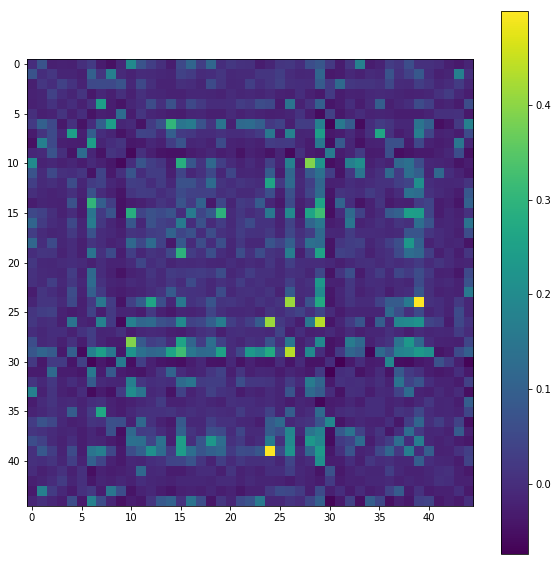

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 481
Average degree:  21.3778


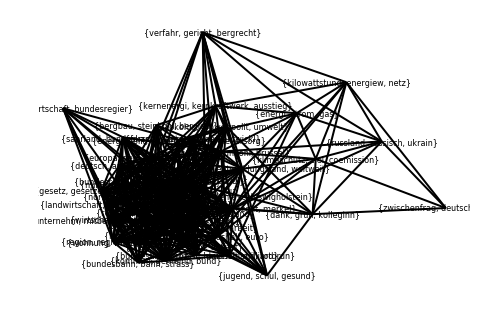

Calculating topic correlation for party spd and period None in run 2111
filtered docs * K: 112455
df shape: (112455, 3)


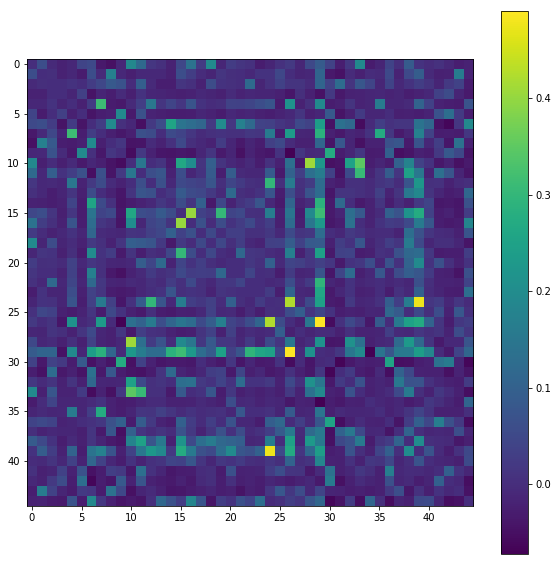

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 531
Average degree:  23.6000


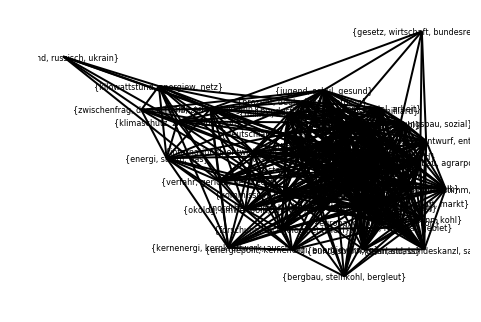

Calculating topic correlation for party cducsu and period None in run 2111
filtered docs * K: 144675
df shape: (144675, 3)


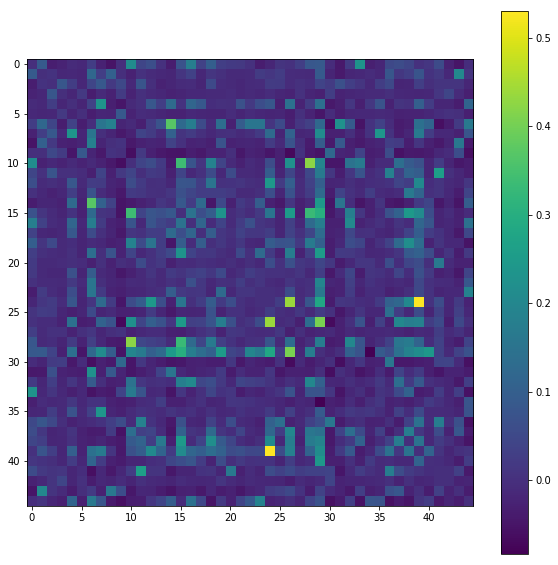

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 483
Average degree:  21.4667


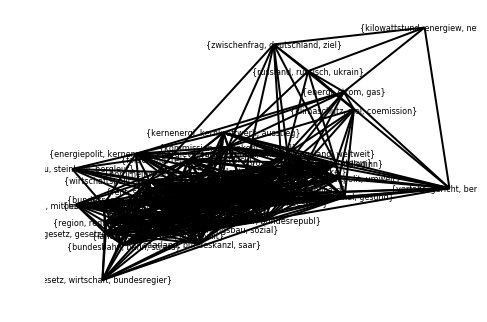

Calculating topic correlation for party fdp and period None in run 2111
filtered docs * K: 67185
df shape: (67185, 3)


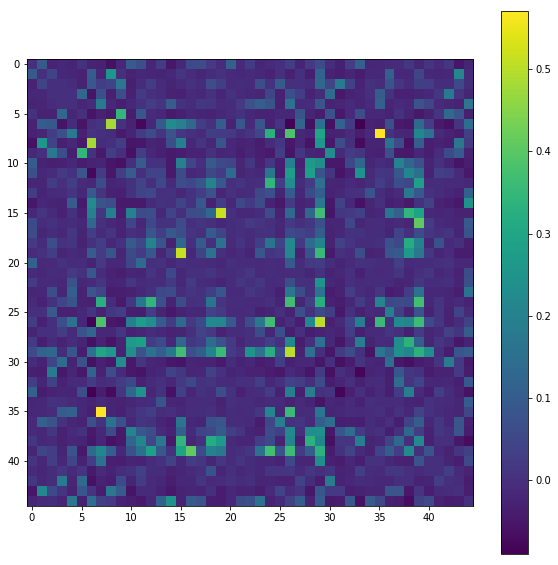

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 437
Average degree:  19.4222


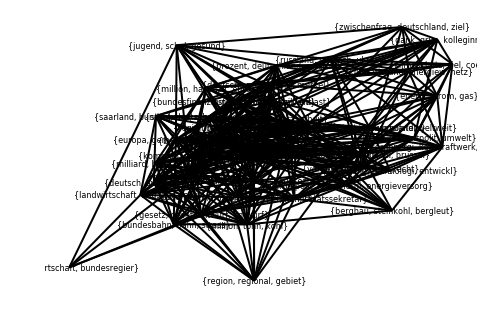

Calculating topic correlation for party linke and period None in run 2111
filtered docs * K: 18270
df shape: (18270, 3)


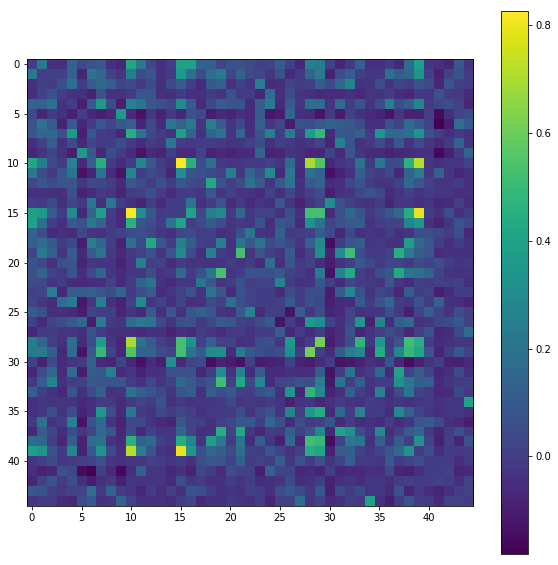

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 527
Average degree:  23.4222


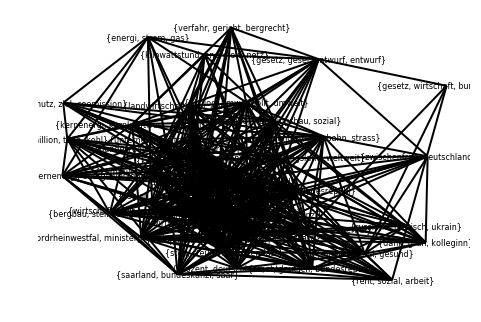

Calculating topic correlation for party gruene and period None in run 2111
filtered docs * K: 44280
df shape: (44280, 3)


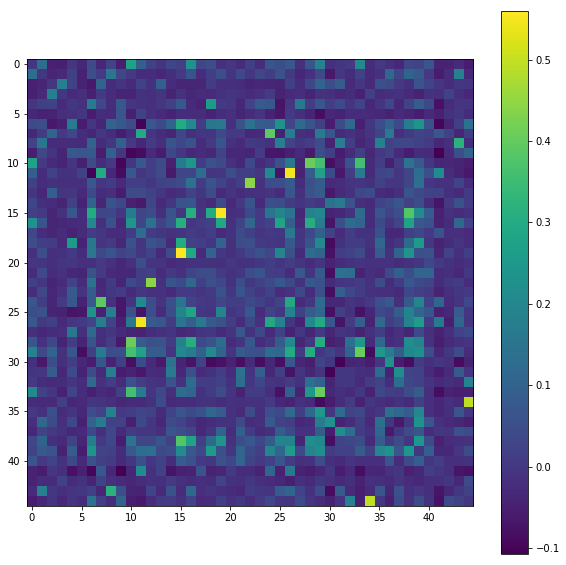

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 488
Average degree:  21.6889


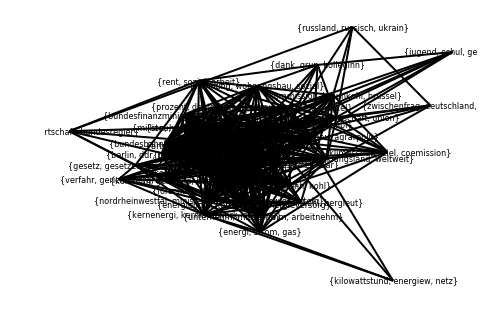

Calculating topic correlation for party afd and period None in run 2111
filtered docs * K: 3375
df shape: (3375, 3)


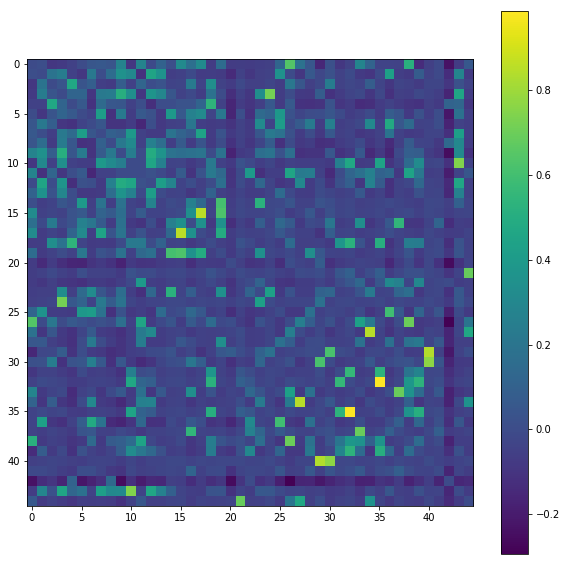

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 337
Average degree:  14.9778


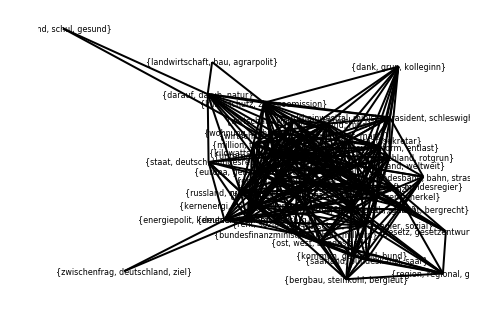

In [10]:
# generate graphs for parties

new_labels = False
threshold0 = True

for party_name in [None, 'spd', 'cducsu', 'fdp', 'linke', 'gruene', 'afd']:

    corr = corr_topics(run_id, party_name=party_name)
    
    show_matrix(corr.replace(to_replace=1, value=0))

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    if party_name:
        scores = {}
        topic_labels = nx.get_node_attributes(G, 'label')
        for node_id, topic_label in topic_labels.items():
            scores[node_id] = float(df_party_scores[topic_label][party_name])
            
        nx.set_node_attributes(G, scores, 'totalscores') 

    if new_labels:
        node_labels = {}
        topic_ids = nx.get_node_attributes(G, 'id')
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
        
        nx.set_node_attributes(G, node_labels, 'label') 
        
    
    #filename = os.path.join(save_dir, 'topic_correlations_run{}_party_{}.graphml'.format(run_id, party_name))
    #nx.write_graphml(G, filename)
    #print("saved graph in {}".format(filename))
    
    show_graph(G)

Calculating topic correlation for party None and period 13 in run 2111
filtered docs * K: 409140
df shape: (27405, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 554
Average degree:  24.6222
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_13.graphml


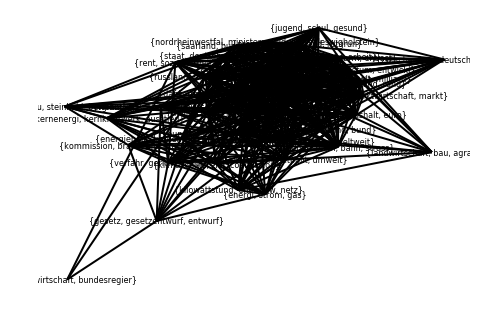

Calculating topic correlation for party None and period 14 in run 2111
filtered docs * K: 409140
df shape: (20970, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 572
Average degree:  25.4222
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_14.graphml


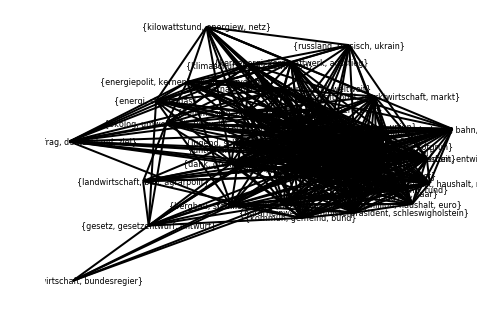

Calculating topic correlation for party None and period 15 in run 2111
filtered docs * K: 409140
df shape: (16605, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 493
Average degree:  21.9111
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_15.graphml


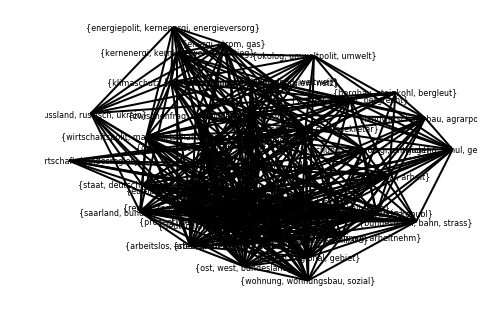

Calculating topic correlation for party None and period 16 in run 2111
filtered docs * K: 409140
df shape: (28620, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 485
Average degree:  21.5556
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_16.graphml


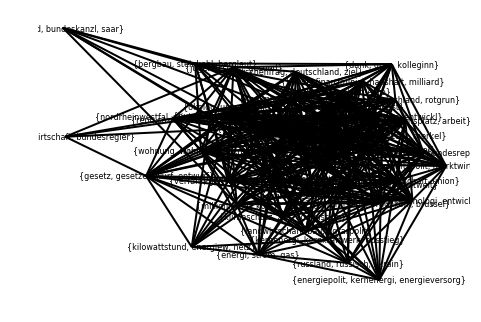

Calculating topic correlation for party None and period 17 in run 2111
filtered docs * K: 409140
df shape: (24660, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 477
Average degree:  21.2000
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_17.graphml


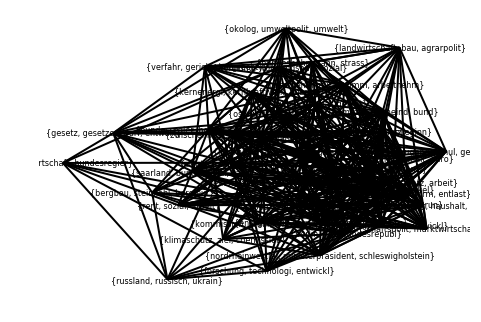

Calculating topic correlation for party None and period 18 in run 2111
filtered docs * K: 409140
df shape: (25830, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 495
Average degree:  22.0000
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_18.graphml


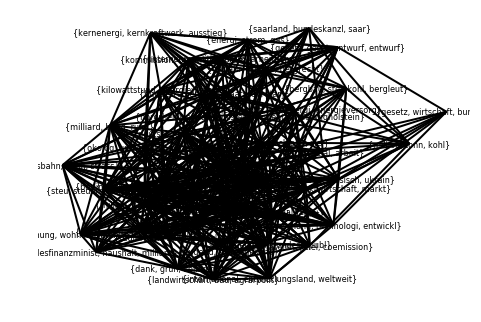

Calculating topic correlation for party None and period 19 in run 2111
filtered docs * K: 409140
df shape: (22950, 3)
Name: 
Type: Graph
Number of nodes: 45
Number of edges: 415
Average degree:  18.4444
saved graph in ./topic_correlations/2111/topic_correlations_run2111_period_19.graphml


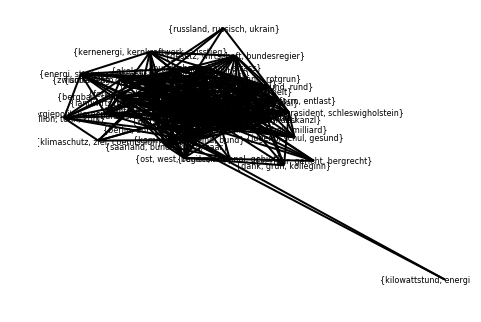

In [9]:
# generate graphs for parliamentary periods

for period in [13, 14, 15, 16, 17, 18, 19]:

    corr = corr_topics(run_id, period=period)

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][period])
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, period))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))
    
    show_graph(G)

# compress folder to easily download it

In [12]:
%%bash
zip -r topic_correlations/1749.zip topic_correlations/1749/

  adding: topic_correlations/1749/ (stored 0%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_17.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_fdp.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_cducsu.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_16.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_14.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_13.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_None.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_afd.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_linke.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_gruene.graphml (deflated 80%)
  ad

In [26]:
nx.get_node_attributes(G, 'label')

{0: 'targets',
 1: 'energy transition 3',
 2: 'power grid',
 3: 'procedural 3',
 4: 'electricity market',
 5: 'development',
 6: 'budget 2',
 7: 'energy transition 2',
 8: 'economy & jobs',
 9: 'conservation',
 10: 'nuclear',
 11: 'climate protection',
 12: 'mixed 3',
 13: 'regional policy',
 14: 'procedural 2',
 15: 'energy transition',
 16: 'economic policy',
 17: 'east germany',
 18: 'procedural 1',
 19: 'budget',
 20: 'mixed 2',
 21: 'climate policy',
 22: 'rail transport',
 23: 'finance',
 24: 'mixed 1',
 25: 'hard coal mining',
 26: 'gas production',
 27: 'biofuels',
 28: 'R&D',
 29: 'EU'}

Calculating topic correlation for spd in run 1739
filtered docs * K: 29520
df shape: (29520, 3)
threshold: 0.06944110454687229
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 80
Average degree:   4.0000


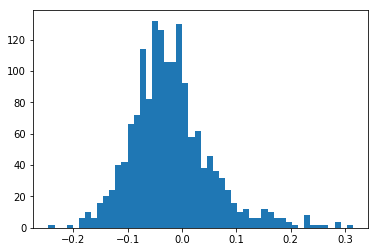

In [30]:
party_name = 'spd'
corr = party_corr_topics(1739, party_name)

threshold = corr_hist(corr, 90)

G = get_graph(corr, threshold)

#nx.write_graphml(G, 'topic_correlations_{}.graphml'.format(party_name))
#show_graph(G)

In [ ]:
# remove duplicates while preserving order

from collections import OrderedDict

terms = Term.objects.filter(topicterm__topic=topic).order_by('-topicterm__score').values('title', 'topicterm__score')[:stat.periods.all().count() * no_top_words]

odict = OrderedDict({})

for t in terms:
    if not t['title'] in odict.keys():
        odict[t['title']] = t['topicterm__score']

#list(OrderedDict.fromkeys(items))
print(odict)
print(len(odict))
